Computational Magnetic Resonance Imaging (CMRI) 2023/2024 Winter semester

- Author : Jinho Kim
- Email : <jinho.kim@fau.de>
- Last update : Nov. 07. 2023

# Lab05: Image Space Parallel Imaging

## Learning objecdtives

- Combine multicoil images
- Reconstruct undersampled multicoil data using SENSE algorithm
- Compute g-factor and compare reconstruction to the ground truth

You will need to get familiar with the functions in scipy.linalg **inv** (matrix inverse) and **pinv** (matrix pseudo-inverse), and the numpy operators **.T**(transpose) and **@** (matrix multiplication).

## Import packages


In [1]:
import numpy as np
import utils
from scipy.linalg import pinv, fractional_matrix_power
import matplotlib.pyplot as plt

## 1. Multicoil combination

### 1-1 Load the file data_brain_8coils.mat.

- d: the fully-sampled k-space data (256×256×8)
  - the dimensions of the data are [PE,FE,channels]
- c is the coil sensitivity maps (256×256×8)
- n is the noise-only scan (256×8).


In [2]:
mat = utils.load_data("data_brain_8coils.mat")
kdata = mat["d"]   # full sampled k-space data, (frequency encoding 256, phase encoding 256, channel 8)
sens_maps = mat["c"]   # coil sensitivity maps (256, 256, 8)
noise_maps = mat["n"]   # noise-only scan
print(f"sensitivity map shape: {noise_maps.shape}")

sensitivity map shape: (256, 8)


### 1-2 Define coil combine algorithms

#### 1-2-1 sum-of-squares


In [3]:
def sos_comb(m):
    """
    Sum of square

    :param m: multicoil images [nPE, nFE, nCh]

    :return: mc: combined image [nPE, nFE]
    """
    # Your code here ...
    m = m.copy()
    #np.sqrt(np.sum(m * m, axis=-1))
    #numerator = np.sum(m.conj() * m, axis=-1)
    #denominator = np.linalg.norm(m, axis=-1) + 1e-8
    #coil_comb_img = numerator / denominator
    coil_comb_img = np.linalg.norm(m, axis=-1)
    return coil_comb_img

#### 1-2-2 matched-filter (least-squares)

$$ f(r) = \frac{\sum^{N_c}_{i=1}{c^*_i(r)m_i(r)}}{\sqrt{\sum^{N_c}_{i=1}{\|c_i(r)\|^2}}} $$

- Pre-whitening

  - $m_w = \Psi^{-\frac{1}{2}}m$
  - $c_w = \Psi^{-\frac{1}{2}}c$
  - Solution
$$ f = (c_w^Hc_w)^{-1}c_w^Hm_w = \frac{c_w^Hm_w}{c_w^Hc_w}$$

- Operator @: (m, n, p) @ (n, q) $\rightarrow$ (m, q, p)


In [4]:
def ls_comb(coil_imgs, sens_maps, PSI=None):
    """
    Least-squares (matched filter)

    :param coil_imgs:               multicoil images [nPE,nFE,nCh] (256, 256, 8)
    :param sens_maps:               coil sensitivity maps [nPE,nFE,nCh] (256, 256, 8)
    :param PSI:                     noise correlation matrix [nCh, nCh]

    :return: coil_comb_img:         combined image [nPE,nFE]
    """
    coil_imgs = coil_imgs.copy()
    sens_maps = sens_maps.copy()

    if PSI is not None:
        PSI = PSI.copy()
        sens_maps = utils.apply_psi(sens_maps, PSI)
        coil_imgs = utils.apply_psi(coil_imgs, PSI)
        PSI_is = fractional_matrix_power(PSI, -1 / 2)
        coil_imgs = (PSI_is @ coil_imgs.transpose(0, 2, 1)).transpose(0, 2, 1)
        sens_maps = (PSI_is @ sens_maps.transpose(0, 2, 1)).transpose(0, 2, 1)
        
    # Your code here ...
    numerator = np.sum(sens_maps.conj() * coil_imgs, axis=-1)   #utils.cmplx_sum(sens_maps * coil_imgs)   # Do c^H_w * m_w => A (256, 256)
    denominator = np.linalg.norm(sens_maps, axis=-1) + 1e-8   #utils.cmplx_sum(sens_maps * sens_maps)   # Do c^H_w * c_w => B (256, 256)
    coil_comb_img = numerator / denominator    # Do (B)^-1 * A
    return coil_comb_img

#### 1.3 Combine the multicoil images using sum-of-squares and matched-filter with and without the coil noise covariance matrix Ψ.


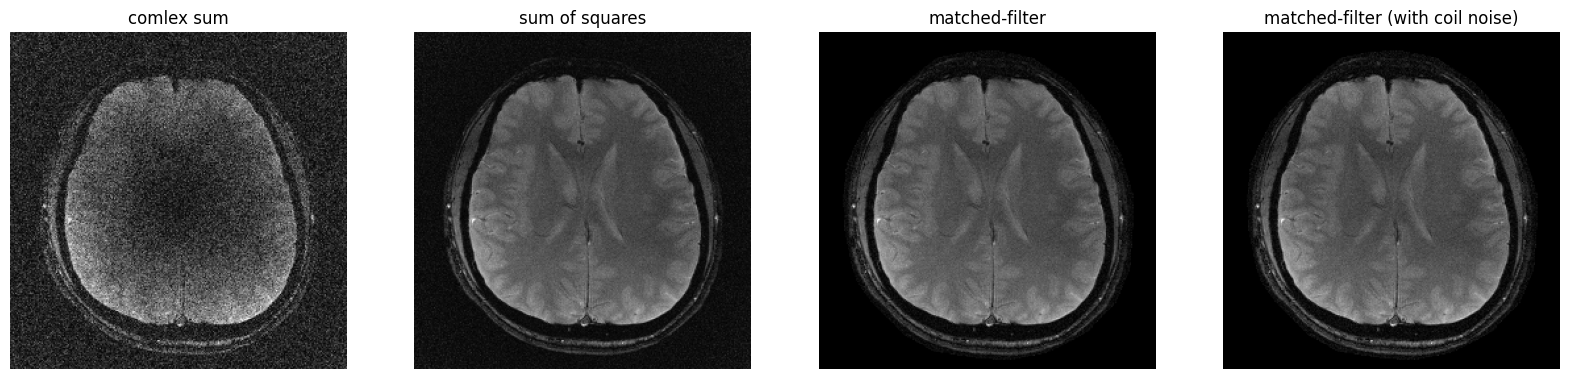

In [5]:
# Your code here ...
coil_imgs = utils.ifft2c(kdata, axes=(0, 1))    # (256, 256, 8)

comlex_sum = utils.cmplx_sum(coil_imgs)   # (256, 256)

# sos_comb
sos_comb_img = sos_comb(coil_imgs)   # (256, 256)

# is_comb
ls_comb_img = ls_comb(coil_imgs, sens_maps)   # (256, 256)

# is_comb with PSI
PSI = np.cov(noise_maps.T)
ls_comb_img_psi = ls_comb(coil_imgs, sens_maps, PSI)

utils.imshow([comlex_sum, sos_comb_img, ls_comb_img, ls_comb_img_psi], titles=["comlex sum", "sum of squares", "matched-filter", "matched-filter (with coil noise)"])

### 1-4 Comment of the effect of using the noise correlation matrix
- why complex_sum does not work?
- and so on ...

## 2. Cartesian SENSE reconstruction and g-factor

- Write a function that reconstructs regularly undersampled data along the phase-encoding dimension using the SENSE method
- computes the corresponding g-factor.
  - The function will unfold multicoil aliased images using coil sensitivity maps in the image domain.

### 2.1 Define functions for SENSE reconstruction
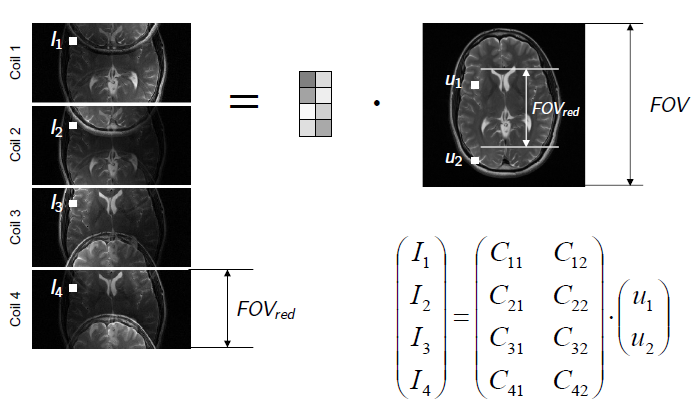

In [6]:
def sense_recon(aliased_imgs, sens_maps, PSI, R):
    """
    SENSE reconstruction

    :param aliased_imgs:        multicoil aliased images [nPE//R,nRO,nCh]
    :param sens_maps:           coil sensitivity maps [nPE,nRO,nCh]
    :param PSI:                 noise correlation matrix [nCh, nCh]
    :param R:                   acceleration factor

    :return:
        unaliased_img:          unaliased image 
        g_map:                  g-factor map 
    """
    PE, RO, _ = sens_maps.shape
    sens_maps = utils.apply_psi(sens_maps, PSI)   # Would you apply PSI here?
    aliased_imgs = utils.apply_psi(aliased_imgs, PSI)   # Would you apply PSI here?

    nonzero_idx = np.array(np.nonzero(np.sum(sens_maps, 2)))
    unaliased_img = np.zeros((PE, RO), dtype=aliased_imgs.dtype)# How would you initialize this? What is the size of SENSE reconstructed image?
    g_map = np.zeros((PE, RO))# How would you initialize this? What is the size of g-factor map?

    for idx_PE, idx_RO in zip(*nonzero_idx): # loop over PE and RO, which are not zeros
        if not unaliased_img[idx_PE, idx_RO]: # if a pixel in unaliased_img at [idx_PE, idx_RO] is not zero, then ...
            
            # SENSE reconstruction
            locs = np.mod(np.arange(idx_PE, PE + idx_PE, PE / R, dtype=int), PE)# How would you get the locations of the aliased image in the PE direction at idx_RO?
            C = sens_maps[locs, idx_RO, :].T# Find the coil sensitivity maps at the locations of the aliased image
            C_pinv = pinv(C)
            idx_PE_alias = utils.get_alias_idx(PE, R, locs)
            unaliased_img[locs, idx_RO] = C_pinv @ aliased_imgs[idx_PE_alias, idx_RO, :]# How would you formulate the matrix calculation in the figure above? Hint: think of C_pinv
            
            # g-factor
            g_map[locs, idx_RO] = utils.calc_g(C)

    return unaliased_img, g_map

### 2.2 Simulate multiple acceleration factors

- R=[2,3,4] along the phase-encoding direction for the provided 8-coil data set.
- Assume that the phase encoding direction is the row dimension (anterior-posterior).

#### 2.2.1 Reconstruct each undersampled data set using your SENSE implementation and compute the corresponding average g-factors.
- When computing the g-factor, consider only values within the brain mask.

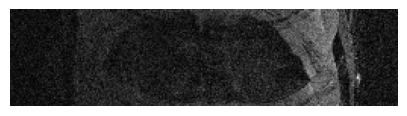

In [7]:
unaliased_imgs = []
g_maps = []
for R in [2, 3, 4]:
    aliased_imgs = utils.ifft2c(kdata[::R], axes=(0, 1)) # undersampled images, 8coils (128, 256, 8)
    # Your code here ...
    unaliased_img, g_map = sense_recon(aliased_imgs, sens_maps, PSI, R)
    unaliased_imgs.append(unaliased_img)
    g_maps.append(g_map)

#### 2.2.2 Plot and compare PSNR and SSIM of accelerated image to that of non-accelerated image.
- Use the matched filter combination as the ground truth.
- To calculate PSNR and SSIM, pass the ground truth via the parameter, *gt*.

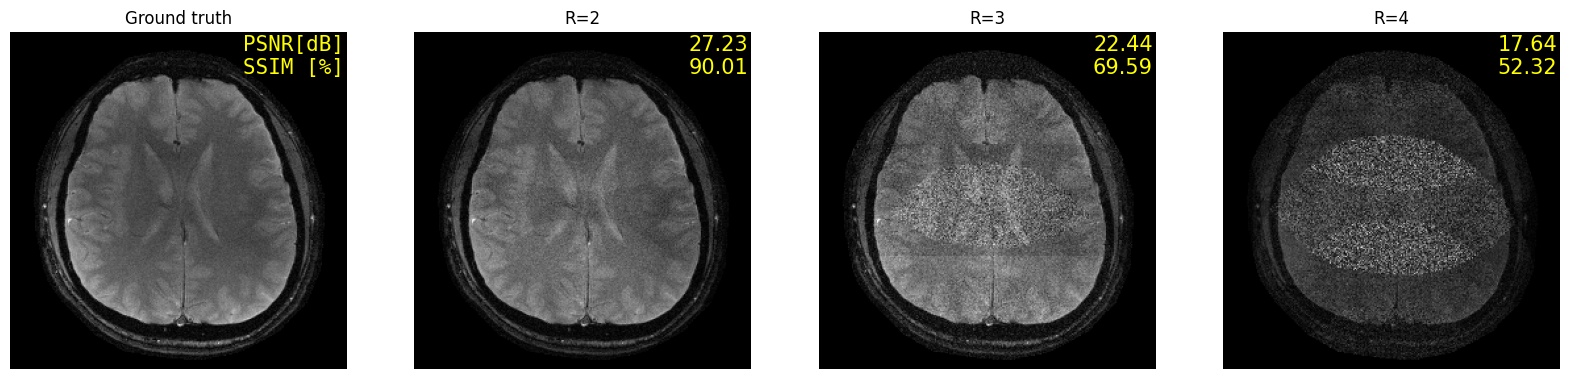

In [8]:
# Your code here ...
utils.imshow(unaliased_imgs, gt=ls_comb_img_psi, titles=["R=2", "R=3", "R=4"], font_size=15, font_color="yellow", font_weight="normal")

#### 2.2.4 Plot the reconstructed image, reconstruction error to the matched-filter combination and g-factor map for each R.
- When taking the difference between two images, do not forget to normalize images. (see utils.normalization())

[1.1727812386468996, 2.1188692569589698, 5.728771962804449]


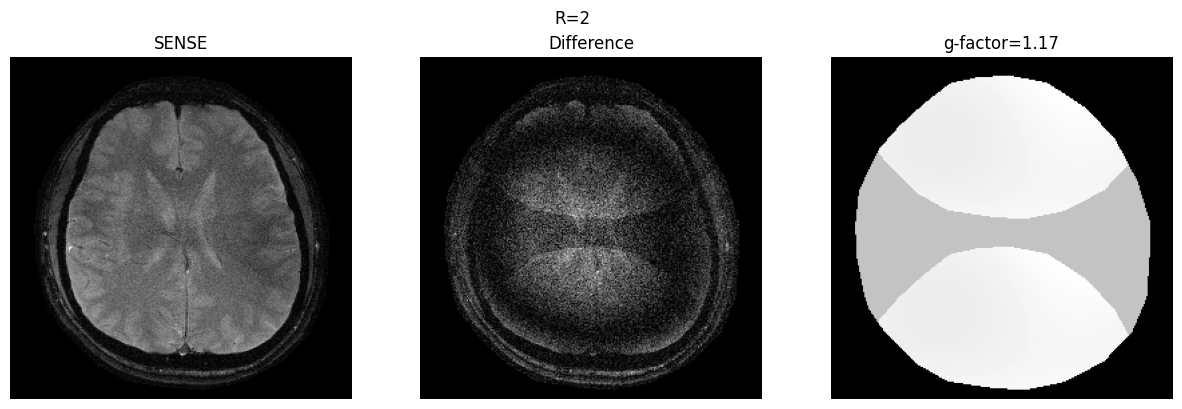

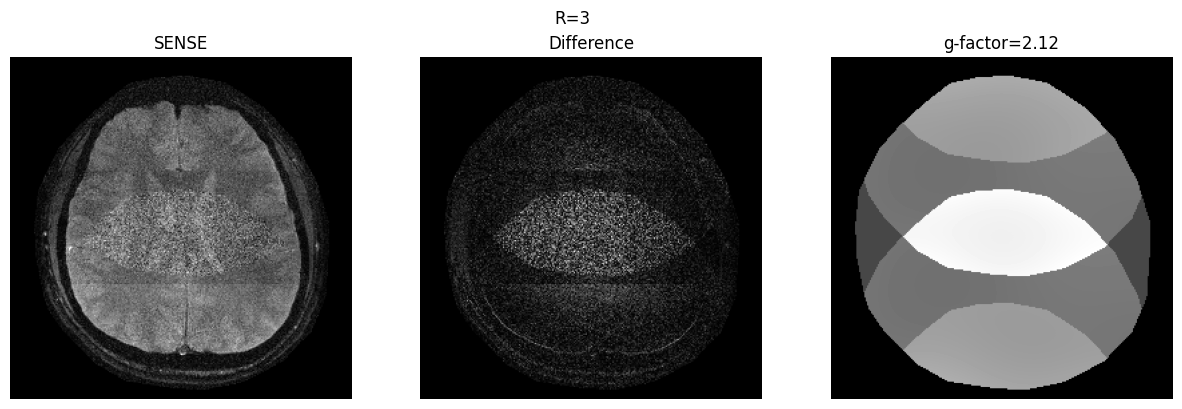

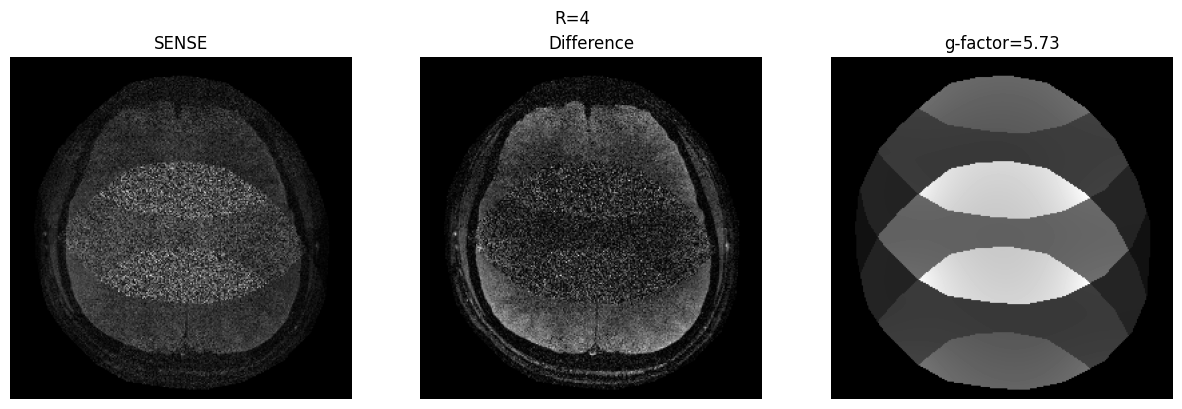

In [10]:
# Your code here ...
imgs = [ls_comb_img_psi] + unaliased_imgs
norm_imgs = []
diff_imgs = []
g_factor = []
for img in imgs:
    norm_imgs.append(utils.normalization(img))

for i in range(1, len(imgs)):
    diff_imgs.append(norm_imgs[0] - norm_imgs[i])
    g_factor.append(np.average(g_maps[i - 1][g_maps[i - 1] != 0]))
print(g_factor)
utils.imshow([unaliased_imgs[0], diff_imgs[0], g_maps[0]], titles=["SENSE", "Difference", "g-factor=1.17"], suptitle="R=2")
utils.imshow([unaliased_imgs[1], diff_imgs[1], g_maps[1]], titles=["SENSE", "Difference", "g-factor=2.12"], suptitle="R=3")
utils.imshow([unaliased_imgs[2], diff_imgs[2], g_maps[2]], titles=["SENSE", "Difference", "g-factor=5.73"], suptitle="R=4")